# Financial Accounting EDA

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [27]:
df = pd.read_csv('../data/double_entry_financial_accounting.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [28]:
#Only use data from accounting period 2022
df['Date'] = df['Date'] - pd.DateOffset(years=1)
df = df[df['Date'].dt.year == 2022]
df.rename(columns={'Transaction_Type': 'Transaction Type'}, inplace=True)

In [29]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              200000 non-null  datetime64[ns]
 1   Account           200000 non-null  object        
 2   Debit             200000 non-null  float64       
 3   Credit            200000 non-null  float64       
 4   Category          200000 non-null  object        
 5   Transaction Type  200000 non-null  object        
 6   Customer_Vendor   200000 non-null  object        
 7   Payment_Method    200000 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 13.7+ MB
None


,Date,Account,Debit,Credit,Category,Transaction Type,Customer_Vendor,Payment_Method
0,2022-03-15,Accounts Receivable,274.79,0.00,Asset,Transfer,Customer 47,Cash
1,2022-03-15,Expense Account,0.00,274.79,Expense,Transfer,Customer 47,Cash
2,2022-12-06,Accounts Receivable,777.34,0.00,Asset,Sale,Customer 9,Credit Card
3,2022-12-06,Liability Account,0.00,777.34,Liability,Sale,Customer 9,Credit Card
4,2022-04-16,Accounts Receivable,566.85,0.00,Asset,Sale,Customer 2,Credit Card


In [8]:
print(df['Transaction Type'].unique())
print(df['Category'].unique())
print(df['Payment_Method'].unique())
print(df['Account'].unique())

['Transfer' 'Sale' 'Expense' 'Purchase']
['Asset' 'Expense' 'Liability' 'Revenue']
['Cash' 'Credit Card' 'Check' 'Bank Transfer']
['Accounts Receivable' 'Expense Account' 'Liability Account'
 'Asset Account' 'Sales Revenue' 'Accounts Payable' 'Inventory' 'Cash'
 'Revenue Account']


## Transaction Analysis

### How many transactions are in each category?

<AxesSubplot:>

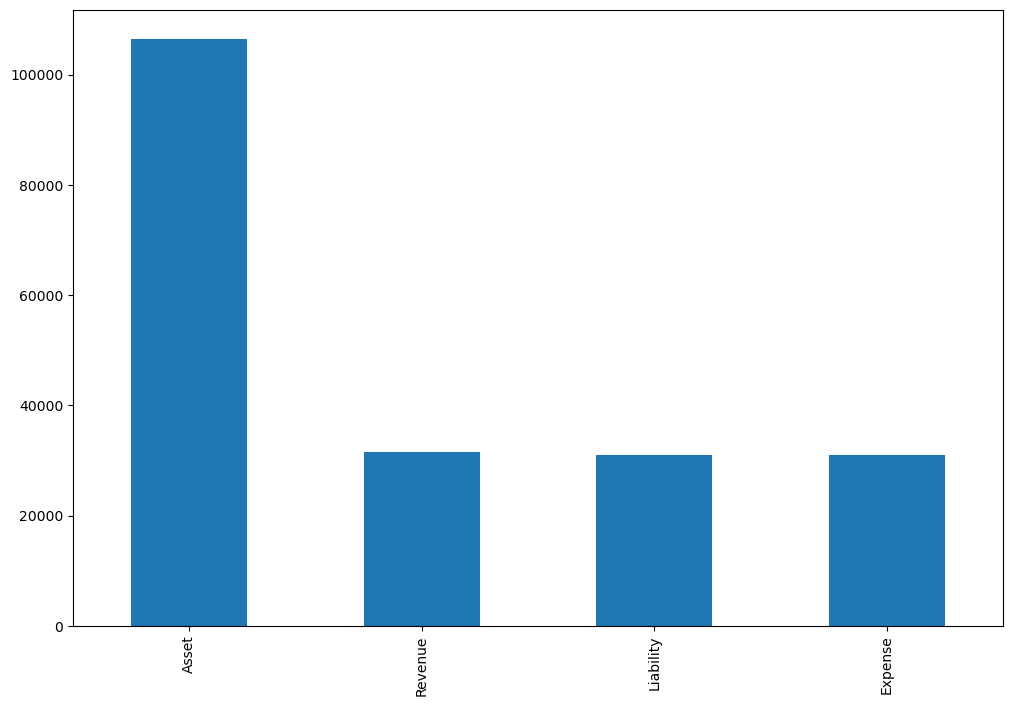

In [10]:
df['Category'].value_counts().plot(kind='bar', figsize=(12, 8))

### How does the transaction volume change month-to-month?

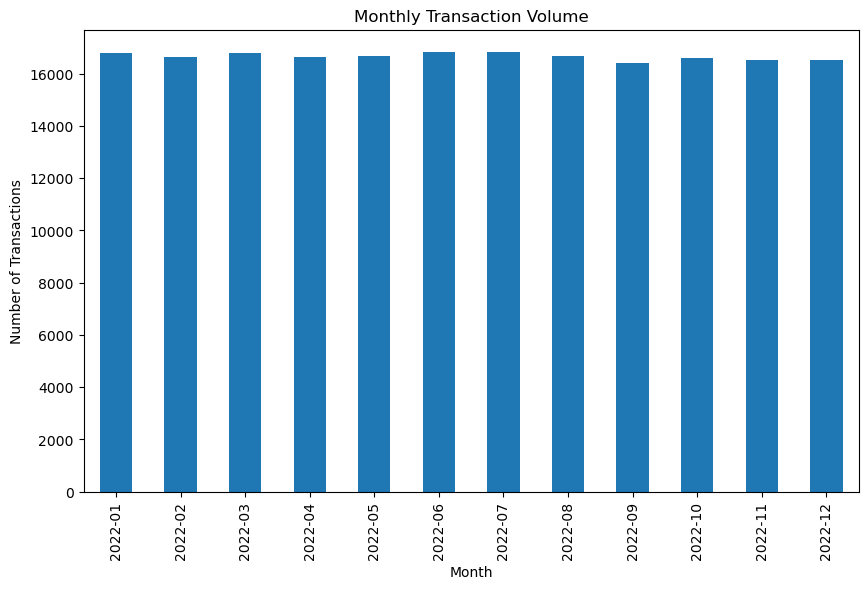

ANOVA Test Results
F-Value: 0.2378371657152704, P-Value: 0.9948882186765989
There is no statistically significant difference in transactions per month.


In [11]:
transaction_volume = df.groupby(df['Date'].dt.to_period('M')).size()

transaction_volume.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Transaction Volume')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

monthly_transactions = [df[df['Month'] == month]['Debit'] for month in df['Month'].unique()]
f_value, p_value = stats.f_oneway(*monthly_transactions)
print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in transactions volume month-to-month.")
else:
    print("There is no statistically significant difference in transactions volume month-to-month.")
df.reset_index(inplace=True)
df.drop(columns=['Month'], inplace=True)

### Distribution of Transaction Types

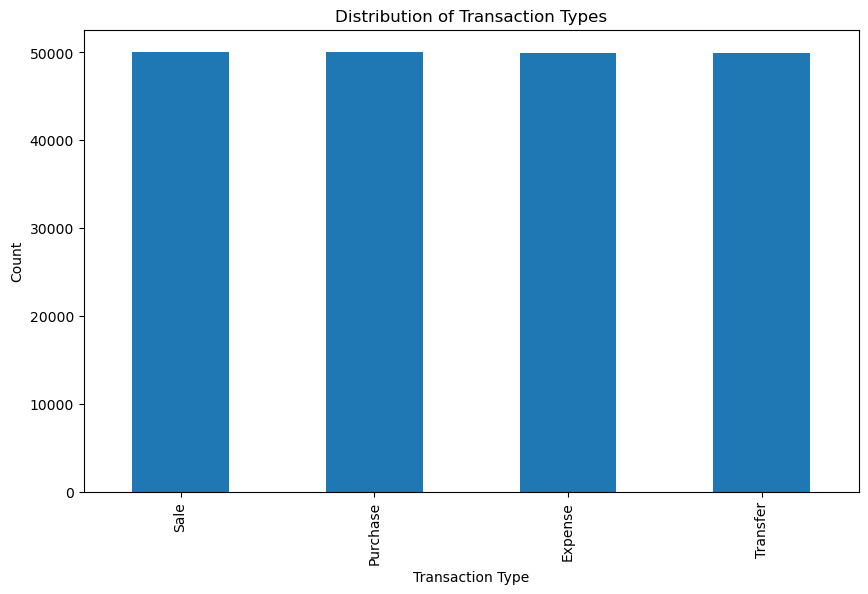

Chi-Square Test Results
Chi-Square Statistic: 0.36144, P-Value: 0.9480876689583654
There is no statistically significant difference in the transaction type counts.


In [12]:
transaction_type_counts = df['Transaction Type'].value_counts()

transaction_type_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

total_count = sum(transaction_type_counts)
num_categories = len(transaction_type_counts)
expected_counts = [total_count / num_categories] * num_categories
chi_square_stat, p_value = stats.chisquare(f_obs=transaction_type_counts, f_exp=expected_counts)

print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in the transaction type counts.")
else:
    print("There is no statistically significant difference in the transaction type counts.")

### Histogram of transaction amounts by category

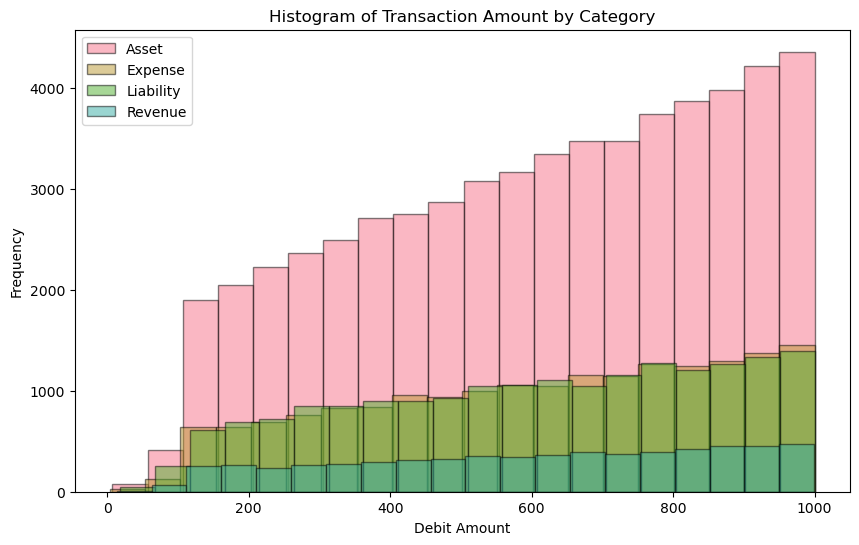

In [18]:
palette = sns.color_palette("husl")
plt.figure(figsize=(10, 6))

for category, color in zip(df.Category.unique(), palette):
    dept_df = df[(df['Category'] == category) & (df['Debit'] > 0)]
    plt.hist(dept_df['Debit'], bins=20, alpha=0.5, label=category, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Transaction Amount by Category')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

### Further comparison of the distribution of transaction amounts by category

In [19]:
filtered_df = df[df['Debit'] > 0]
f_value, p_value = stats.f_oneway(filtered_df[filtered_df['Category'] == 'Asset']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Expense']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Liability']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Revenue']['Debit'])

print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of transaction amounts by category.")
    print("Post-Hoc Analysis (Tukey's HSD Test):")
    mc = MultiComparison(filtered_df['Debit'], filtered_df['Category'])
    result = mc.tukeyhsd() 
    print(result)
else:
    print("There is no statistically significant difference in the distribution of transaction amounts by category.")

ANOVA Test Results
F-Value: 2.594940296693603, P-Value: 0.05068056682278576
There is no statistically significant difference in the distribution of transaction amounts by category.


## Transaction Analysis by Account

### Does transaction volume vary by department?

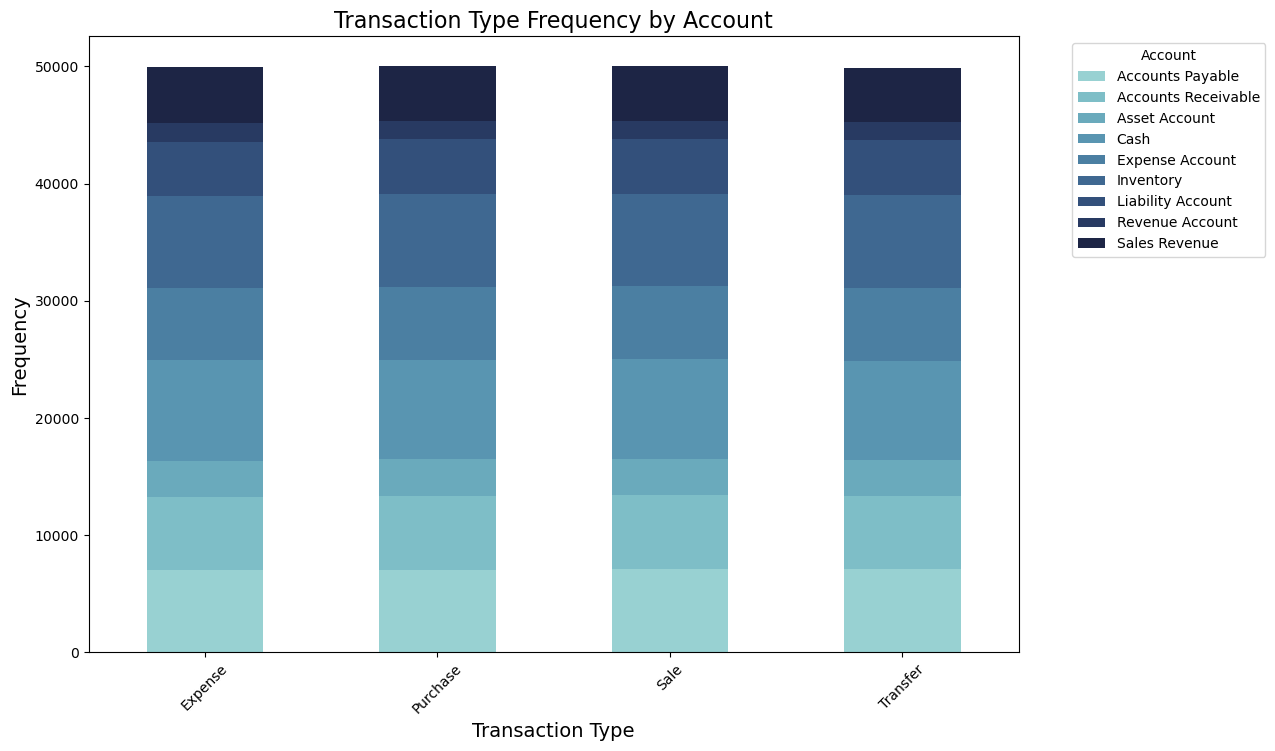

Chi-Square Test Results
Chi-Square Statistic: 8.371452888437618, P-Value: 0.9986641649404867
There is no statistically significant relationship between Account and volume per Transaction Type.


In [31]:
grouped_data = df.groupby(['Transaction Type', 'Account']).size().unstack(fill_value=0)
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Account.nunique())
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=palette)
plt.title('Transaction Type Frequency by Account', fontsize=16)
plt.xlabel('Transaction Type', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Account', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

contingency_table = pd.crosstab(df['Account'], df['Transaction Type'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

if p < 0.05:
    print("There is a statistically significant relationship between Account and volume per Transaction Type.")
else:
    print("There is no statistically significant relationship between Account and volume per Transaction Type.")

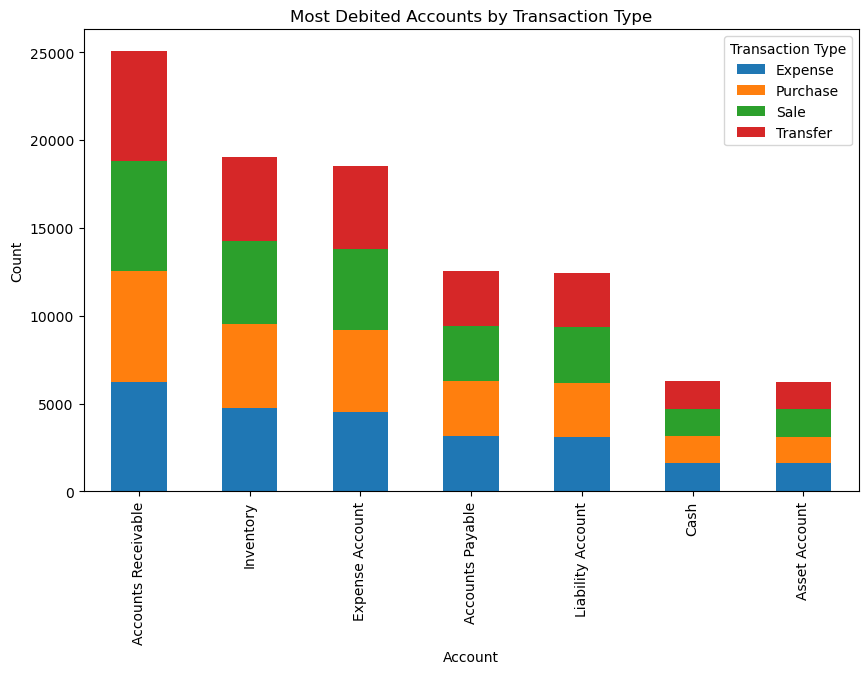

In [69]:
debited_df = df[df['Debit'] > 0]

grouped = debited_df.groupby(['Account', 'Transaction_Type']).size().reset_index(name='Count')
pivot_df = grouped.pivot(index='Account', columns='Transaction_Type', values='Count').fillna(0)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df_sorted = pivot_df.sort_values(by='Total', ascending=False)
pivot_df_sorted = pivot_df_sorted.drop(columns=['Total'])

pivot_df_sorted.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Most Debited Accounts by Transaction Type')
plt.xlabel('Account')
plt.ylabel('Count')
plt.legend(title='Transaction Type')
plt.show()

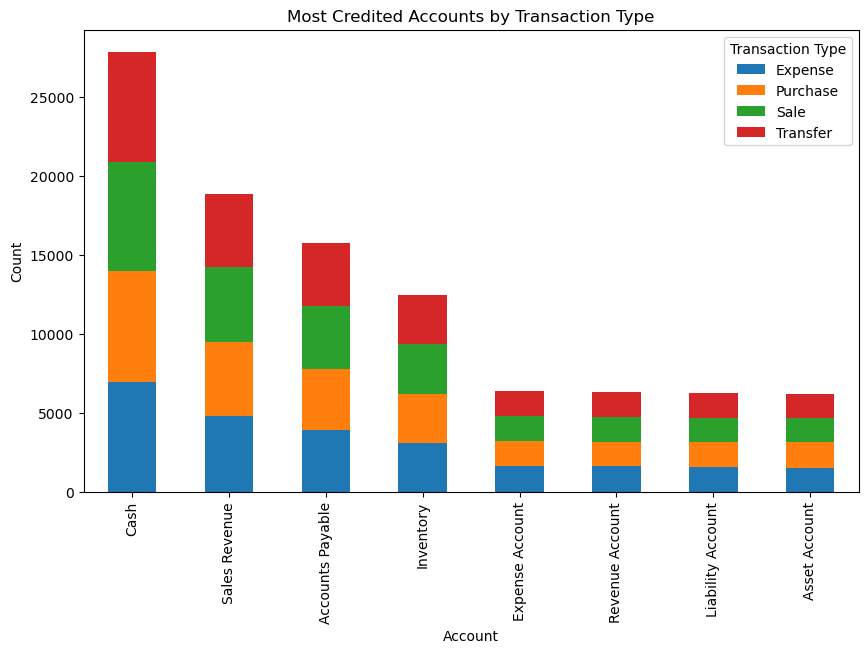

In [70]:
debited_df = df[df['Credit'] > 0]

grouped = debited_df.groupby(['Account', 'Transaction_Type']).size().reset_index(name='Count')
pivot_df = grouped.pivot(index='Account', columns='Transaction_Type', values='Count').fillna(0)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df_sorted = pivot_df.sort_values(by='Total', ascending=False)
pivot_df_sorted = pivot_df_sorted.drop(columns=['Total'])

pivot_df_sorted.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Most Credited Accounts by Transaction Type')
plt.xlabel('Account')
plt.ylabel('Count')
plt.legend(title='Transaction Type')
plt.show()

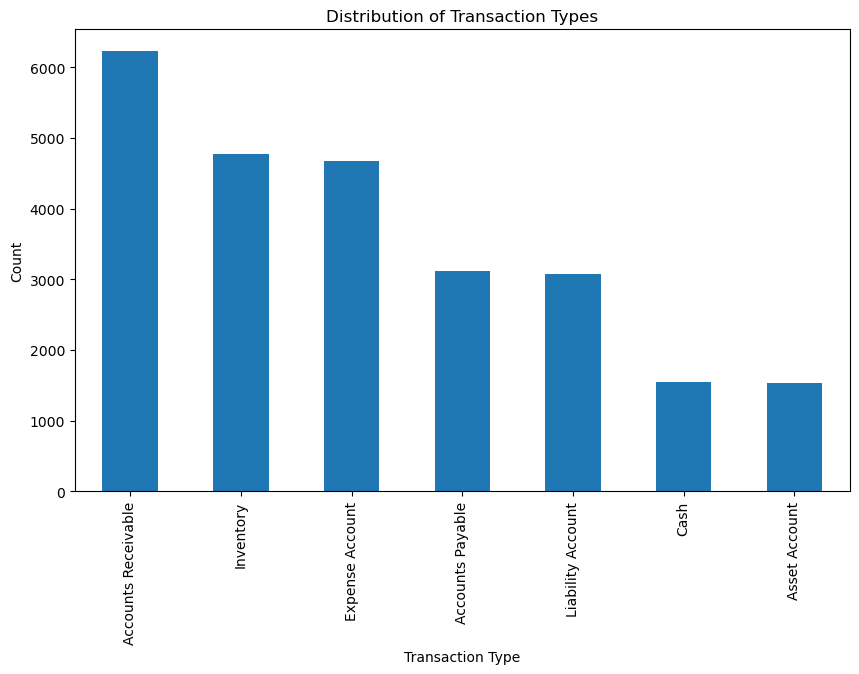

In [62]:
transfer_counts = df[(df['Transaction_Type'] == 'Transfer') & (df['Debit'] > 0)].Account.value_counts()

transfer_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

## Customer Transaction Analysis

In [45]:
df['Customer_Vendor'].nunique()

100

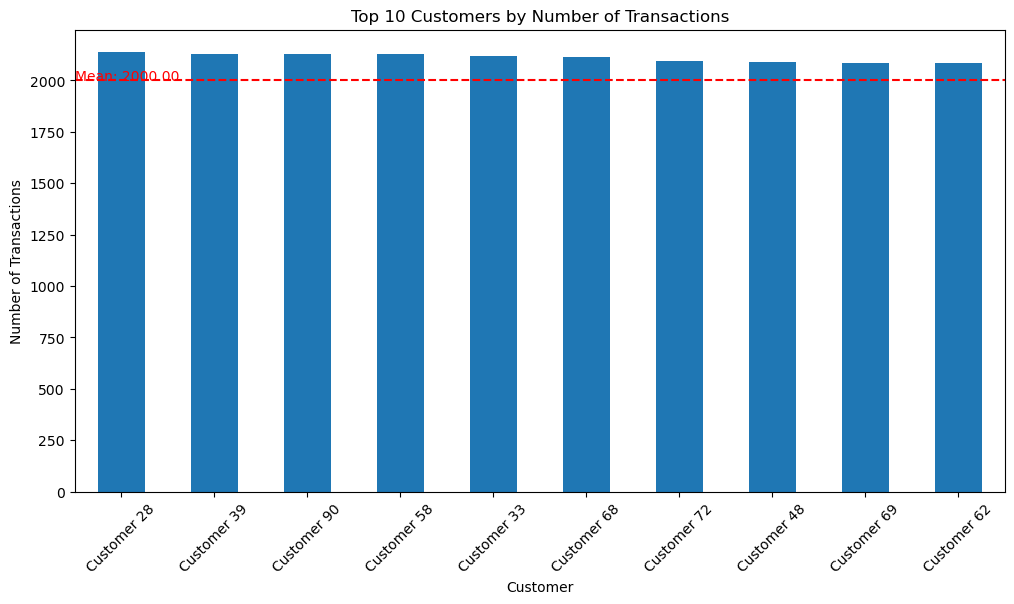

Chi-Square Test Results
Chi-Square Statistic: 1.9791469194312796, P-Value: 0.9917930879313669
There is no statistically significant difference in the number of transactions per customer.


In [24]:
customer_transaction_counts = df['Customer_Vendor'].value_counts().head(10)
mean_transaction_count = df['Customer_Vendor'].value_counts().mean()

plt.figure(figsize=(12, 6))
customer_transaction_counts.plot(kind='bar')
plt.title('Top 10 Customers by Number of Transactions')
plt.xlabel('Customer')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

plt.axhline(y=mean_transaction_count, color='red', linestyle='--')
plt.text(x=-0.5, y=mean_transaction_count + 1, s=f'Mean: {mean_transaction_count:.2f}', color='red')
plt.show()


total_count = sum(customer_transaction_counts)
num_customers = len(customer_transaction_counts)
expected_counts = [total_count / num_customers] * num_customers

chi_square_stat, p_value = stats.chisquare(f_obs=customer_transaction_counts, f_exp=expected_counts)

print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")

alpha = 0.05 
if p_value < alpha:
    print("There is a statistically significant difference in the number of transactions per customer.")
else:
    print("There is no statistically significant difference in the number of transactions per customer.")

## Payment Methods

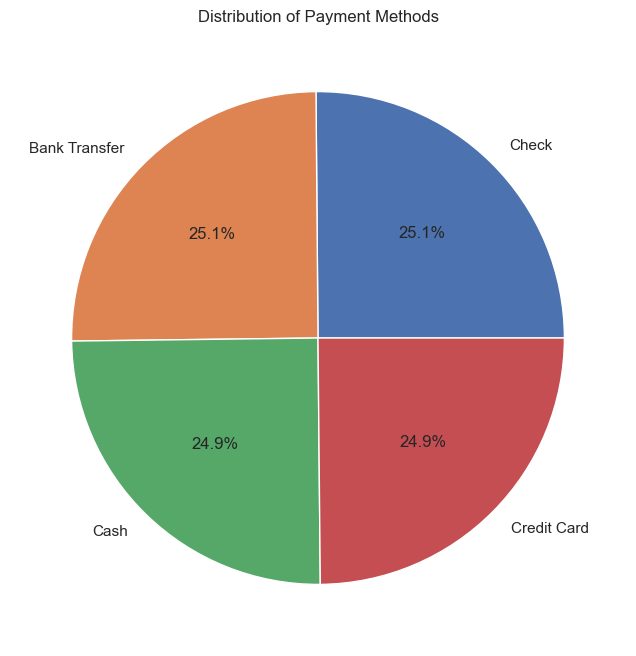

Chi-Square Test Results
Chi-Square Statistic: 3.7379200000000004, P-Value: 0.29119012174304565
There is no statistically significant difference in the use of different payment methods annually.


In [86]:
payment_method_counts = df['Payment_Method'].value_counts()

payment_method_counts.plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%')
plt.title('Distribution of Payment Methods')
plt.ylabel('')
plt.show()

total_count = sum(payment_method_counts)
num_methods = len(payment_method_counts)
expected_counts = [total_count / num_methods] * num_methods

chi_square_stat, p_value = stats.chisquare(f_obs=payment_method_counts, f_exp=expected_counts)
print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in the use of different payment methods annually.")
else:
    print("There is no statistically significant difference in the use of different payment methods annually.")

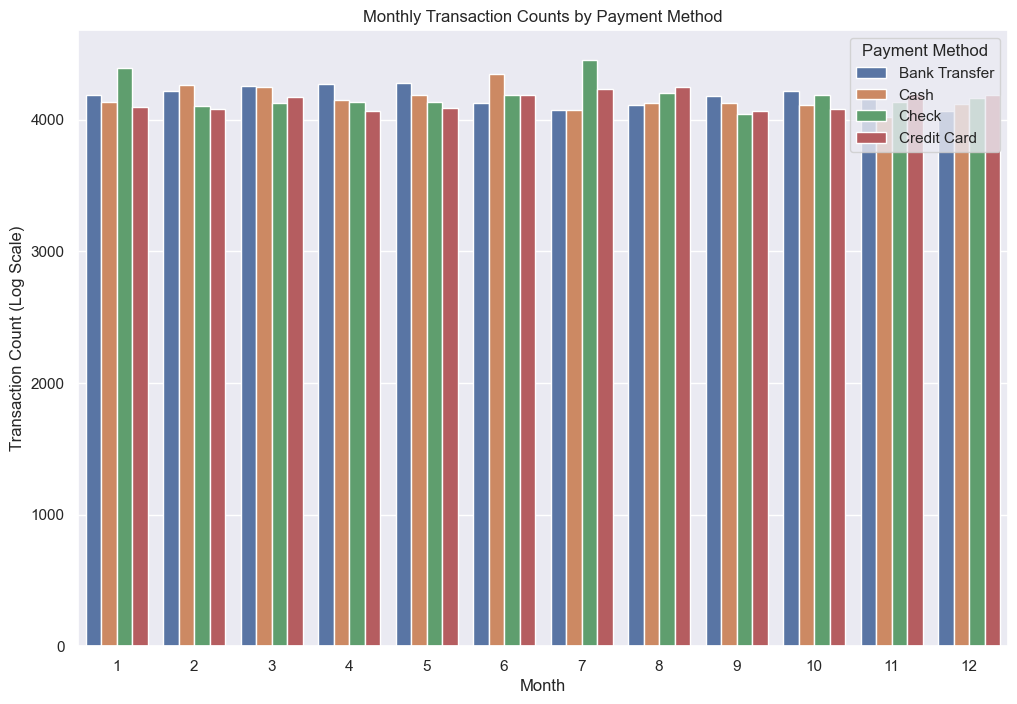

Chi-Square Test of Independence Results
Chi-Square Statistic: 70.71640917035214, P-Value: 0.0001467628758449358
There is a statistically significant relationship between month and payment method.


In [88]:
df['Month'] = df['Date'].dt.month
contingency_table = pd.crosstab(df['Month'], df['Payment_Method'])
chi_square_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

long_form = contingency_table.reset_index().melt(id_vars='Month', var_name='Payment_Method', value_name='Count')
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='Count', hue='Payment_Method', data=long_form)

plt.title('Monthly Transaction Counts by Payment Method')
plt.xlabel('Month')
plt.ylabel('Transaction Count (Log Scale)')
plt.legend(title='Payment Method')
plt.show()


print("Chi-Square Test of Independence Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant relationship between month and payment method.")
else:
    print("There is no statistically significant relationship between month and payment method.")

### Is there a relationship between payment method and mean transaction amount?

ANOVA Test Results
F-Value: 0.2378371657152704, P-Value: 0.9948882186765989


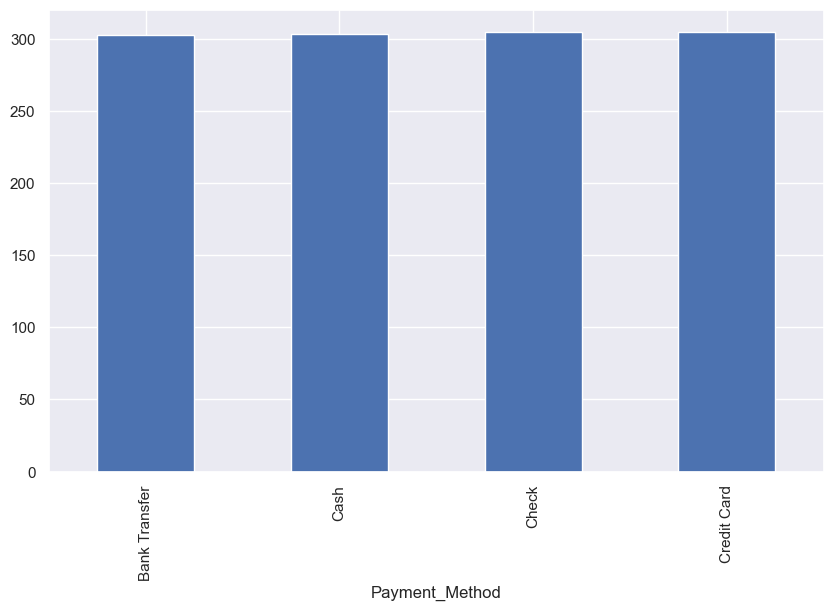

In [94]:
average_transaction_amount = df.groupby('Payment_Method')['Debit'].mean()
average_transaction_amount.plot(kind='bar', figsize=(10, 6))
f_value, p_value = stats.f_oneway(*monthly_transactions)

print("ANOVA Test Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant relationship between month and payment method.")
else:
    print("There is no statistically significant relationship between month and payment method.")

### Is there a correlation between transaction types and payment methods?
Given the p-value of the chi-square test, there is no statistically significant correlation between transaction types and payment methods.

In [44]:
cross_tab = pd.crosstab(df['Transaction_Type'], df['Payment_Method'])
chi2, p_value, dof, expected = stats.chi2_contingency(cross_tab)
print("Chi-Square Test Result:", p_value)

if p_value < 0.05:
    print("There is a statistically significant relationship between transaction type and payment method.")
else:
    print("There is no statistically significant relationship between transaction type and payment method.")

Chi-Square Test Result: 0.20615039666510257
There is no statistically significant relationship between transaction type and payment method.


## Categorical Analysis

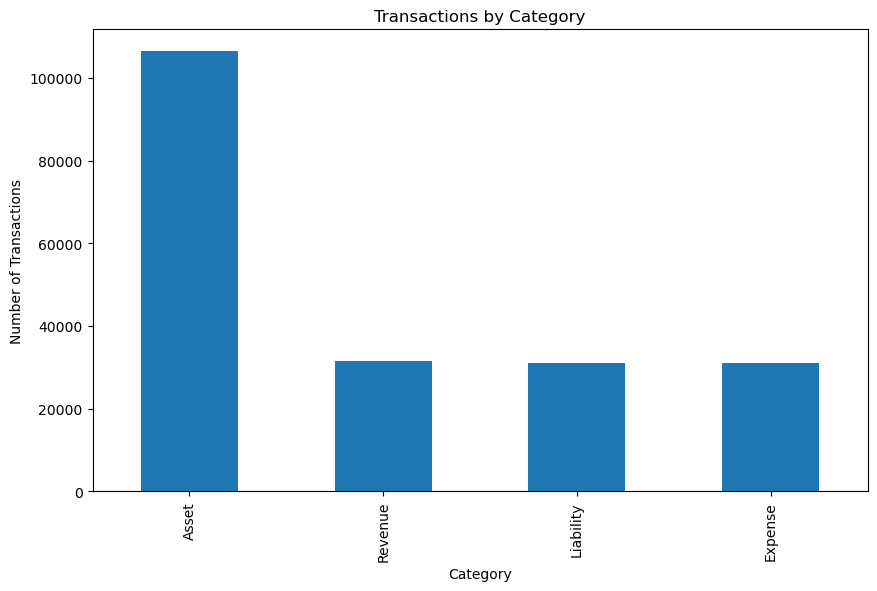

In [27]:
category_counts = df['Category'].value_counts()
category_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.show()

## Debit and Credit Analysis per Account

**Debit**: An accounting entry that either increases an asset or expense account, or decreases a liability or equity account.<br>
**Credit**: An accounting entry that either increases a liability or equity account, or decreases an asset or expense account.

*Per [AccountingTools](https://www.accountingtools.com/articles/debits-and-credits)*

In [28]:
account_totals = df.groupby('Account').agg({'Debit': 'sum', 'Credit': 'sum'})

### Debits

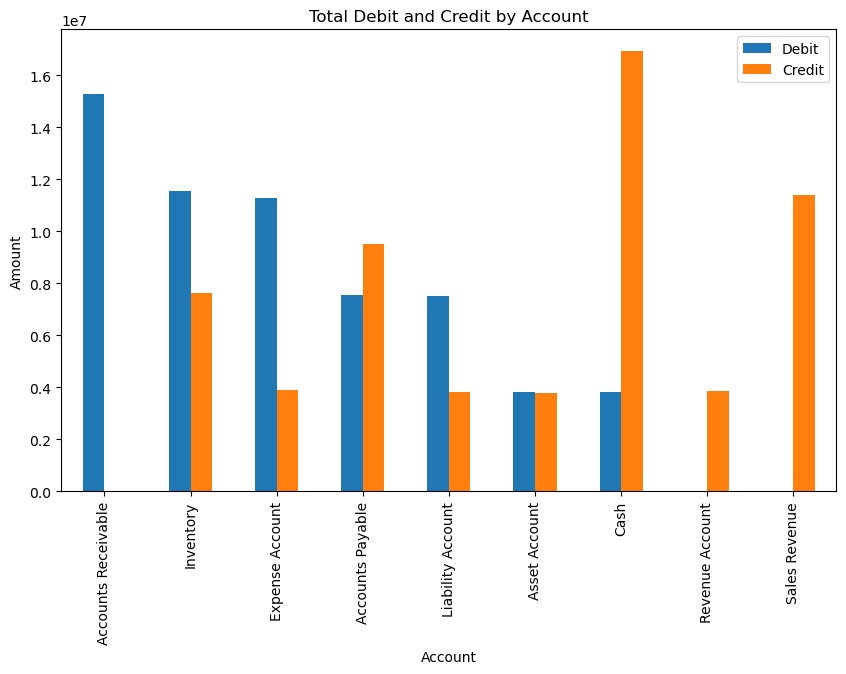

In [29]:
account_totals.sort_values(by='Debit', ascending=False, inplace=True)
account_totals.plot(kind='bar', figsize=(10, 6))
plt.title('Total Debit and Credit by Account')
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

#### Interpreting Debits

**Debit to Accounts Receivable**<br>


### Credits

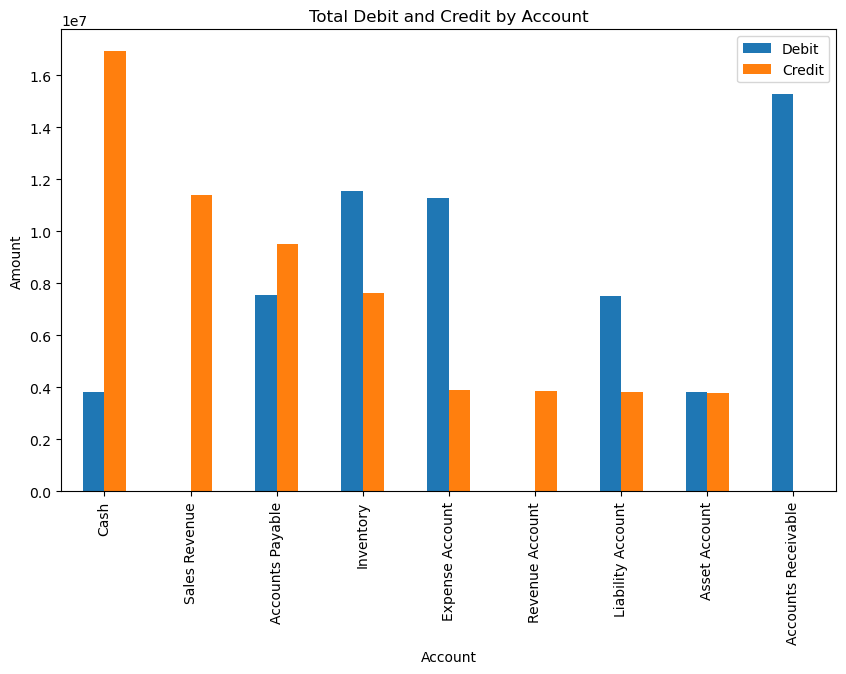

In [30]:
account_totals.sort_values(by='Credit', ascending=False, inplace=True)
account_totals.plot(kind='bar', figsize=(10, 6))
plt.title('Total Debit and Credit by Account')
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

#### Interpreting Credits

**Credit to sales revenue account**<br>
In accounting, credit entries to revenue accounts signify an increase in revenue. This might seem counterintuitive because we normally think of credits as something that decreases an account, but in accounting, credits increase revenue accounts because revenues signify increases in owners' equity. [Source](https://www.accountingtools.com/articles/why-are-revenues-credited.html#:~:text=One%20side%20of%20the%20entry,balance%20sheet%20remain%20in%20balance.)

## Statistical Questions

### Is there a significant difference in the average transaction amounts for different transaction types?

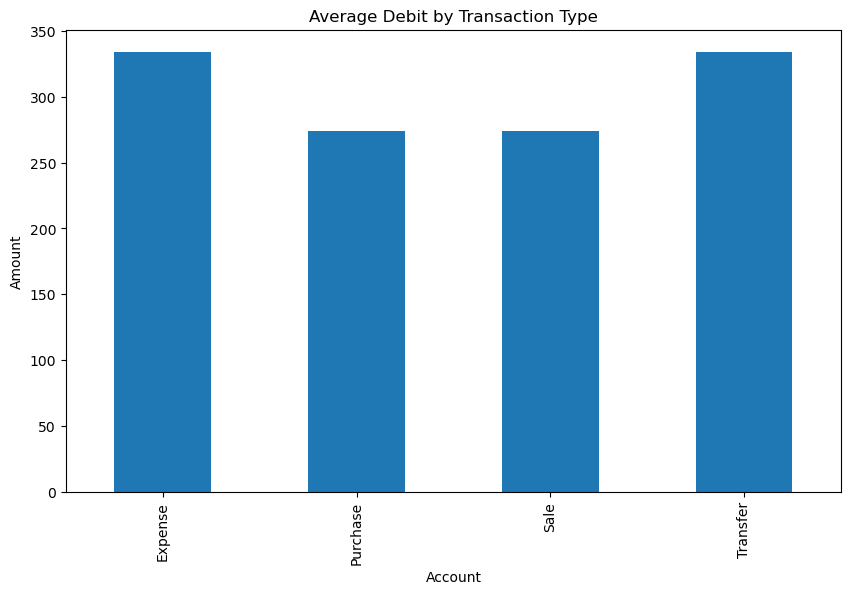

ANOVA Test Result: F_onewayResult(statistic=490.18870341891414, pvalue=2.1052424e-317)


In [32]:
average_transaction_amounts = df.groupby('Transaction_Type')['Debit'].mean()

anova_results = stats.f_oneway(df[df['Transaction_Type'] == 'Sale']['Debit'],
                               df[df['Transaction_Type'] == 'Purchase']['Debit'],
                               df[df['Transaction_Type'] == 'Transfer']['Debit'],
                               df[df['Transaction_Type'] == 'Expense']['Debit'])


average_transaction_amounts.plot(kind='bar', figsize=(10, 6))
plt.title('Average Debit by Transaction Type')
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()
print("ANOVA Test Result:", anova_results)


## Statistical Questions

### What is the trend in revenue and expenses over the year?

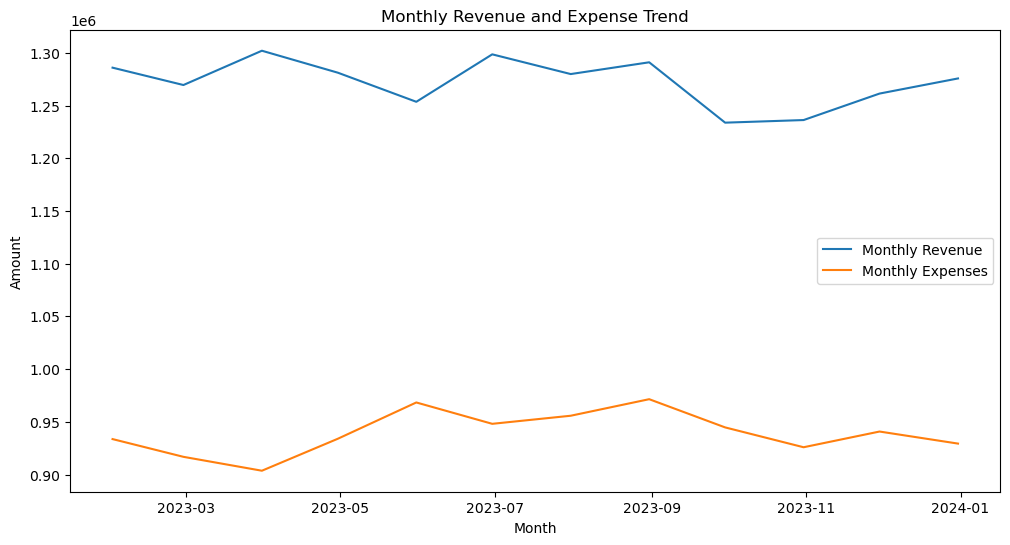

In [34]:
df_trend = df.copy()
df_trend['Date'] = pd.to_datetime(df_trend['Date'])

df_trend.set_index('Date', inplace=True)

revenue_df = df_trend[df_trend['Category'] == 'Revenue']
expense_df = df_trend[df_trend['Category'] == 'Expense']

monthly_revenue = revenue_df.resample('M')['Credit'].sum()
monthly_expenses = expense_df.resample('M')['Debit'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, label='Monthly Revenue')
plt.plot(monthly_expenses.index, monthly_expenses.values, label='Monthly Expenses')
plt.title('Monthly Revenue and Expense Trend')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Are sales increasing? Are expenses growing faster than revenue?

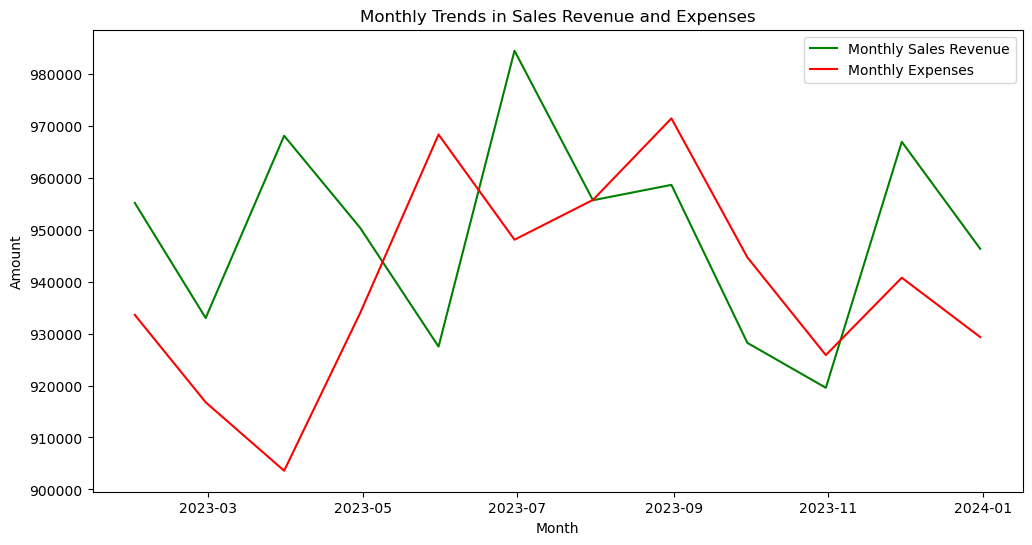

In [35]:
df_trend = df.copy()
df_trend['Date'] = pd.to_datetime(df_trend['Date'])

df_trend.set_index('Date', inplace=True)
sales_revenue = df_trend[df_trend['Account'] == 'Sales Revenue'].resample('M')['Credit'].sum()

expenses = df_trend[df_trend['Account'] == 'Expense Account'].resample('M')['Debit'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales_revenue.index, sales_revenue.values, label='Monthly Sales Revenue', color='green')
plt.plot(expenses.index, expenses.values, label='Monthly Expenses', color='red')

plt.title('Monthly Trends in Sales Revenue and Expenses')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.show()

#### Perform Linear Regression Test
Per the linear regression test below, there is no statistically significant trend (increasing or decreasing) in sales, expenses, or revenue over time.

In [36]:
numeric_dates = np.arange(len(sales_revenue))
slope, intercept, r_value, p_value, std_err = linregress(numeric_dates, sales_revenue.values)
print(f"Slope: {slope}, P-value: {p_value}")

numeric_dates = np.arange(len(expenses))
slope, intercept, r_value, p_value, std_err = linregress(numeric_dates, expenses.values)
print(f"Slope: {slope}, P-value: {p_value}")

Slope: -622.355349650351, P-value: 0.7204644796447632
Slope: 1382.7180419580413, P-value: 0.43347488292498415
